## Categorical Feature Support in Gradient Boosting

https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_categorical.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-categorical-py


In [1]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml(data_id=41211, as_frame=True, return_X_y=True)

n_categorical_features = (X.dtypes == 'category').sum()
n_numerical_features = (X.dtypes == 'float').sum()
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of categorical features: {n_categorical_features}")
print(f"Number of numerical features: {n_numerical_features}")

C:\Users\Yael Shushlav\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\datasets\_openml.py:849: UserWarning: Version 1 of dataset ames-housing is inactive, meaning that issues have been found in the dataset. Try using a newer version from this URL: https://www.openml.org/data/v1/download/20649135/ames-housing.arff
  warn("Version {} of dataset {} is inactive, meaning that issues have "


Number of samples: 2930
Number of features: 80
Number of categorical features: 46
Number of numerical features: 34


In [2]:
# As a baseline, we create an estimator where the categorical features are dropped:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

dropper = make_column_transformer(
    ('drop', make_column_selector(dtype_include='category')),
    remainder='passthrough')
hist_dropped = make_pipeline(dropper,
                             HistGradientBoostingRegressor(random_state=42))

Next, we create a pipeline that will one-hot encode the categorical features and let the rest of the numerical data to passthrough:

In [3]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = make_column_transformer(
    (OneHotEncoder(sparse=False, handle_unknown='ignore'),
     make_column_selector(dtype_include='category')),
    remainder='passthrough')

hist_one_hot = make_pipeline(one_hot_encoder,
                             HistGradientBoostingRegressor(random_state=42))

Next, we create a pipeline that will treat categorical features as if they were ordered quantities, i.e. the categories will be encoded as 0, 1, 2, etc., and treated as continuous features.

In [4]:
from sklearn.preprocessing import OrdinalEncoder
import numpy as np

ordinal_encoder = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan),
     make_column_selector(dtype_include='category')),
    remainder='passthrough')

hist_ordinal = make_pipeline(ordinal_encoder,
                             HistGradientBoostingRegressor(random_state=42))

We now create a HistGradientBoostingRegressor estimator that will natively handle categorical features. This estimator will not treat categorical features as ordered quantities.

Since the HistGradientBoostingRegressor requires category values to be encoded in [0, n_unique_categories - 1], we still rely on an OrdinalEncoder to pre-process the data.

In [5]:
# The main difference between this pipeline and the previous one is that in this one, we let the HistGradientBoostingRegressor know which features are categorical.
# The ordinal encoder will first output the categorical features, and then the
# continuous (passed-through) features
categorical_mask = ([True] * n_categorical_features +
                    [False] * n_numerical_features)
hist_native = make_pipeline(
    ordinal_encoder,
    HistGradientBoostingRegressor(random_state=42,
                                  categorical_features=categorical_mask)
)

Finally, we evaluate the models using cross validation. Here we compare the models performance in terms of mean_absolute_percentage_error and fit times.

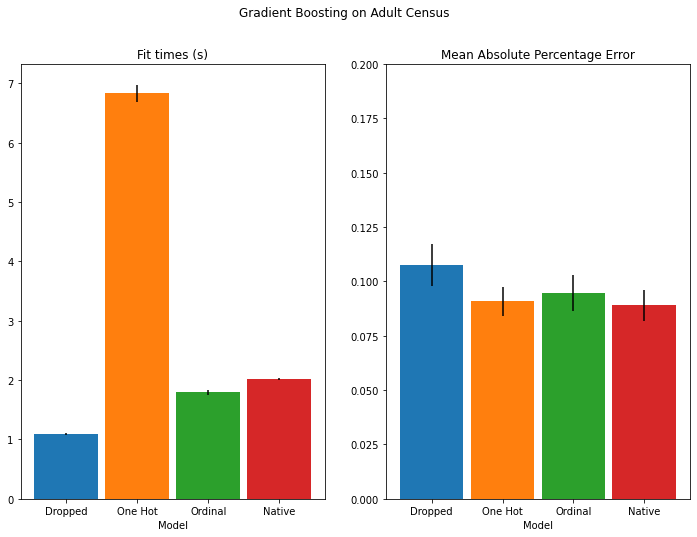

In [6]:
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt

scoring = "neg_mean_absolute_percentage_error"
dropped_result = cross_validate(hist_dropped, X, y, cv=3, scoring=scoring)
one_hot_result = cross_validate(hist_one_hot, X, y, cv=3, scoring=scoring)
ordinal_result = cross_validate(hist_ordinal, X, y, cv=3, scoring=scoring)
native_result = cross_validate(hist_native, X, y, cv=3, scoring=scoring)


def plot_results(figure_title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

    plot_info = [('fit_time', 'Fit times (s)', ax1, None),
                 ('test_score', 'Mean Absolute Percentage Error', ax2,
                  (0, 0.20))]

    x, width = np.arange(4), 0.9
    for key, title, ax, y_limit in plot_info:
        items = [dropped_result[key], one_hot_result[key], ordinal_result[key],
                 native_result[key]]
        ax.bar(x, [np.mean(np.abs(item)) for item in items],
               width, yerr=[np.std(item) for item in items],
               color=['C0', 'C1', 'C2', 'C3'])
        ax.set(xlabel='Model', title=title, xticks=x,
               xticklabels=["Dropped", "One Hot", "Ordinal", "Native"],
               ylim=y_limit)
    fig.suptitle(figure_title)


plot_results("Gradient Boosting on Adult Census")


We see that the model with one-hot-encoded data is by far the slowest. This is to be expected, since one-hot-encoding creates one additional feature per category value (for each categorical feature), and thus more split points need to be considered during fitting. In theory, we expect the native handling of categorical features to be slightly slower than treating categories as ordered quantities (‘Ordinal’), since native handling requires sorting categories. Fitting times should however be close when the number of categories is small, and this may not always be reflected in practice.

In terms of prediction performance, dropping the categorical features leads to poorer performance. The three models that use categorical features have comparable error rates, with a slight edge for the native handling.